# <center>**明星脸识别**</center>
<hr></hr>  

### <center>**实战实验报告**</center>
#### **<center>控制科学与工程学院&emsp;3200100259&emsp;沈骏一</center>**

# 1.题目介绍

## 1.1 题目背景
随着短视频、直播、网剧的流程，越来越多的“小鲜肉”出现在大家的视野中，小红对现在的“小鲜肉”如数家珍，经常发他们的照片在朋友圈，可她的爷爷奶奶却分不清，你能否开发一个机器学习模型。帮助爷爷奶奶辨认图片上的明星是谁呢？

## 1.2 题目要求
1) 任务提供包括数据读取、基础模型、模型训练等基本代码  
2) 参赛选手需完成核心模型构建代码，并尽可能将模型调到最佳状态  
3) 模型单次推理时间不超过 10 秒  

## 1.3 实验环境
可以使用基于 Python 的 OpenCV 库进行图像相关处理，使用 Numpy 库进行相关数值运算，使用 Tensorflow，Keras，pytorch 等框架建立深度学习模型等。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

# 2.题目内容
## 2.1 介绍数据集   
该数据集包含了 1800 张各个明星的照片，对应的文件夹以他们的姓名命名。
数据集中的照片来自 10 位明星，每个明星 180 张照片，分别是：

| 序号 | 名字   | 名字缩写 | 照片个数 |
| :----: | :----: |:----: | :----: |
| 1    | 刘亦菲 | LYF |   180      |
| 2    | 刘昊然 | LHR | 180      |
| 3    | 刘诗诗 | LSS |180      |
| 4    | 彭于晏   | PYY |180      |
| 5    | 唐嫣   | TY |180      |
| 6    | 成龙   | CL |180      |
| 7    | 杨幂   | YM |180      |
| 8    | 胡歌   | HG |180      |
| 9   | 范冰冰 | FBB |180      |
| 10   | 何炅 | HJ |180      |

- 照片为网上爬取，图片大小尺寸不同

In [ ]:
# 导入相关包
import glob, os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

# 数据集路径
data_path = "./dataset"

# 获取数据名称列表
img_list = glob.glob(os.path.join(data_path, '*/*.jpg'))

# 打印数据集总量
print("数据集总数量:", len(img_list))
print("数据路径和名称:",img_list[0])

数据集总数量: 1800
数据路径和名称: ./dataset/HG/126_1.jpg


数据集总共有 1800 张图片，现在随机展示其中的 6 张图片。

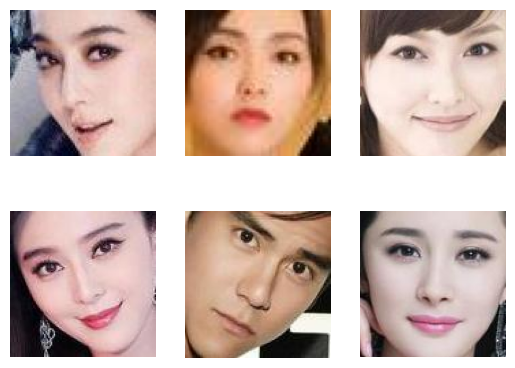

In [ ]:
import random,cv2
import numpy as np
import matplotlib.pyplot as plt

# 从数据名称列表 img_list 中随机选取 6 个。
for i, img_path in enumerate(random.sample(img_list, 6)):
    
    # 读取图片
    img = cv2.imread(img_path)
    
    # 将图片从 BGR 模式转为 RGB 模式
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 将窗口设置为 2 行 3 列 6个子图
    plt.subplot(2, 3, i + 1)
    
    # 展示图片
    plt.imshow(img)
    
    # 不显示坐标尺寸
    plt.axis('off')

- 获取图像形状  
img.shape 可以获得图像的形状，返回值是一个包含行数，列数，通道数的元组

In [ ]:
# 随机选取一张图片
path = random.sample(img_list, 1)

# 读取图片
img = cv2.imread(path[0])

# 将图片从 BGR 模式转为 RGB 模式
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# 获取图片的形状
img.shape

(155, 155, 3)

## 2.2 图片预处理

图片生成器 ImageDataGenerator: tensorflow.keras.preprocessing.image 模块中的图片生成器，主要用以生成一个 batch 的图像数据，支持实时数据提升。训练时该函数会无限生成数据，直到达到规定的 epoch 次数为止。同时也可以在 batch 中对数据进行增强，扩充数据集大小，增强模型的泛化能力，比如进行旋转，变形，归一化等等。

图片生成器的主要方法：

fit(x, augment=False, rounds=1, seed=None)：计算依赖于数据的变换所需要的统计信息(均值方差等)。

flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None)：接收 Numpy 数组和标签为参数,生成经过数据提升或标准化后的 batch 数据，并在一个无限循环中不断的返回 batch 数据。

flow_from_directory(directory): 以文件夹路径为参数，会从路径推测 label，生成经过数据提升/归一化后的数据，在一个无限循环中无限产生 batch 数据。
参考链接：https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

以上只是对图片生成器进行简单的介绍，详细信息请参考中英文链接。
根据上面的介绍和我们数据集的特性，我们主要运用 ImageDataGenerator() 和 flow_from_directory() 方法。我们将数据处理过程封装成为一个函数：

In [ ]:
# 导入图片生成器
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def processing_data(data_path, height, width, batch_size=32, validation_split=0.1):
    """
    数据处理
    :param data_path: 带有子目录的数据集路径
    :param height: 图像形状的行数
    :param width: 图像形状的列数
    :param batch_size: batch 数据的大小，整数，默认32。
    :param validation_split: 在 0 和 1 之间浮动。用作测试集的训练数据的比例，默认0.1。
    :return: train_generator, validation_generator: 处理后的训练集数据、验证集数据
    """

    train_data = ImageDataGenerator(
            # 对图片的每个像素值均乘上这个放缩因子，把像素值放缩到0和1之间有利于模型的收敛
            rescale=1. / 255,  
            # 浮点数，剪切强度（逆时针方向的剪切变换角度）
            shear_range=0.1,  
            # 随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]
            zoom_range=0.1,
            # 浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度
            width_shift_range=0.1,
            # 浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度
            height_shift_range=0.1,
            # 布尔值，进行随机水平翻转
            horizontal_flip=True,
            # 布尔值，进行随机竖直翻转
            vertical_flip=True,
            # 在 0 和 1 之间浮动。用作验证集的训练数据的比例
            validation_split=validation_split  
    )

    # 接下来生成测试集，可以参考训练集的写法
    validation_data = ImageDataGenerator(
            rescale=1. / 255,
            validation_split=validation_split)

    train_generator = train_data.flow_from_directory(
            # 提供的路径下面需要有子目录
            data_path, 
            # 整数元组 (height, width)，默认：(256, 256)。 所有的图像将被调整到的尺寸。
            target_size=(height, width),
            # 一批数据的大小
            batch_size=batch_size,
            # "categorical", "binary", "sparse", "input" 或 None 之一。
            # 默认："categorical",返回 one-hot 编码标签。
            class_mode='categorical',
            # 数据子集 ("training" 或 "validation")
            subset='training', 
            seed=0)
    validation_generator = validation_data.flow_from_directory(
            data_path,
            target_size=(height, width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            seed=0)

    return train_generator, validation_generator

In [ ]:
# 数据路径
data_path = "./dataset"

# 图像数据的行数和列数
height, width = 200, 200

# 获取训练数据和验证数据集
train_generator, validation_generator = processing_data(data_path, height, width)

# 通过属性class_indices可获得文件夹名与类的序号的对应字典。 (类别的顺序将按照字母表顺序映射到标签值)。
labels = train_generator.class_indices
print(labels)

# 转换为类的序号与文件夹名对应的字典
labels = dict((v, k) for k, v in labels.items())
print(labels)

但是，考虑到具体目标的可行性与具踢框架的掌握程度  
我们选择沿用任务二的`Pytorch`框架进行任务解决

## 2.3 建立深度学习模型
依托pytorch框架建立所需要的人脸识别模型  
首先导入所需要的包

In [ ]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

###  2.3.1 数据处理
建立数据处理函数，从数据集中创建Dataloader对象

In [ ]:
def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

通过调用`process_data`函数，可以生成需要的训练集与测试集   
经过一系列`Transformer`操作使模型具有一定稳定性的同时也具有可靠的泛化能力。

###  2.3.2 训练模型

建立名为`ArcfaceNet`的模型，主要由`ResNet50`残差神经网络与一层线性组成  
转换成Tensor的图片向量经过50层残差神经网络生成一个512维的特征向量   
再输入到线性层形成2维的预测，经过`softmax`操作形成输出

In [ ]:
from model import Backbone
class ArcfaceNet(nn.Module):
    def __init__(self, classes=10):
        super(ArcfaceNet, self).__init__()
        self.Arcnet = Backbone(num_layers=50,drop_ratio=0.6,mode='ir_se')
        self.Arcnet.load_state_dict(torch.load('model_ir_se50.pth'))
        self.fc = nn.Linear(512, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.Arcnet(x)
        out = self.fc(x)
        out = self.softmax(out)
        return out

残差网络主干模型：


In [ ]:
class Backbone(Module):
    def __init__(self, num_layers, drop_ratio, mode='ir'):
        super(Backbone, self).__init__()
        assert num_layers in [50, 100, 152], 'num_layers should be 50,100, or 152'
        assert mode in ['ir', 'ir_se'], 'mode should be ir or ir_se'
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1 ,bias=False), 
                                      BatchNorm2d(64), 
                                      PReLU(64))
        self.output_layer = Sequential(BatchNorm2d(512), 
                                       Dropout(drop_ratio),
                                       Flatten(),
                                       Linear(512 * 7 * 7, 512),
                                       BatchNorm1d(512))
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)
    
    def forward(self,x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return l2_norm(x)

判断是否采用GPU训练

In [ ]:
torch.cuda.is_available()

True

加载数据集，并设置训练参数（lr、epoch等）

In [ ]:
data_path = './dataset'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=112, width=112, batch_size=42)

epochs = 60
model = ArcfaceNet(classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=5e-4)  # 优化器
print('加载完成...')

加载完成...


学习率的手动设置可以使模型训练更加高效。  
这里我们设置当模型在两轮迭代后，准确率没有上升，就调整学习率。

In [ ]:
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.5,
                                                 patience=2)
# 损失函数
criterion = nn.CrossEntropyLoss()  

开始模型训练

In [ ]:
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()
    model.Arcnet.requires_grad = False
    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)


        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)
    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/temp.pth')
print('Finish Training.')

为了缩减报告长度，这里删除了上述训练过程的结果，具体可以看后文`2.3.3`Loss图像发现大概趋势

### 2.3.3 展示模型训练过程

In [ ]:
train_result = []
for loss in loss_list :
    train_result.append(loss.detach().to('cpu').numpy())

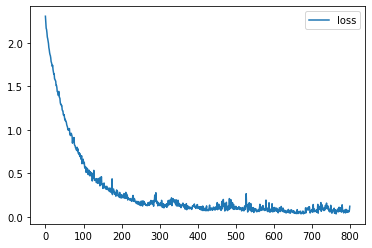

In [32]:
plt.plot(train_result,label = "loss")
plt.legend()
plt.show()

训练过程系统参数：  
![Alt text](Screenshot%20from%202022-12-03%2014-16-10.png)   
![Alt text](Screenshot%20from%202022-12-03%2014-18-09.png)  
可以发现网络输入显卡消耗了巨大的显存资源

训练模型的测试：

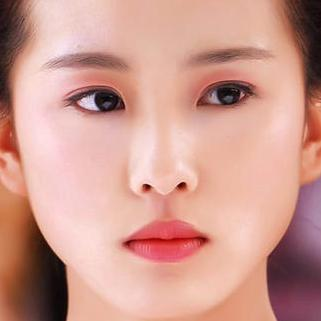

LSS


In [58]:
testpic = Image.open('t2.jpg')
labels = {0:'CL',1:'FBB',2:'HG',3:'HJ',4:'LHR',5:'LSS',6:'LYF',7:'PYY',8:'TY',9:'YM'}
testpic.show()
test_trans = T.Compose([
        T.Resize((112, 112)),
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])
testpic = test_trans(testpic)
testpic = testpic.view(1,testpic.shape[0],testpic.shape[1],testpic.shape[2])
model.eval()
with torch.no_grad():
    result = model(testpic.to(device))
    result = labels[np.argmax(result.to('cpu').numpy())]
print(result)


### 2.3.4 全网络的训练  
借助AutoDL平台，我们将前期的残差神经网络也放开，进行全网络的训练

得出训练损失图如下所示：   
![Alt text](Screenshot%20from%202022-12-05%2009-49-09.png)  
可以看到，损失函数在下降一定程度后趋于收敛    
训练过程系统用量：  
![Alt text](Screenshot%20from%202022-12-03%2014-17-42.png)  

很遗憾的是，在后续的系统测试中，准确率并没有达到比较大的提升。   
这表明之前加载的预训练模型对于人脸的表达能力已经趋于很强的水准。

### 2.3.5 引入新的损失函数  
受到`Arcface`的启发，我们尝试引入该论文提出的一种新的损失函数`Archead`  
提取`model.py`中Archead的主体代码，并加入到全开放训练的损失函数当中

In [ ]:
class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

然而，训练结果并不是很理想，在200个epoch后仍出现了较大程度的损失：  
step:200/200 || Total Loss: 35.5122  
综上，最后的测试环节并没有选用该训练模型。

# 3 模型预测
注意：
1. 点击左侧栏`提交结果`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。**注意不要勾选训练模型的代码**。 
2. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
4. `predict()`函数的输入和输出请不要改动。
5. 测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from model import Backbone

# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 star.h5 模型，则 model_path = 'results/star.h5'
model_path = 'res50.pth'

# 加载模型，如果采用keras框架训练模型，则 model=load_model(model_path)
class ArcfaceNet(nn.Module):
    def __init__(self, classes=10):
        super(ArcfaceNet, self).__init__()
        self.Arcnet = Backbone(num_layers=50,drop_ratio=0.6,mode='ir_se')
        #self.Arcnet.load_state_dict(torch.load('model_ir_se50.pth'))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.Arcnet(x)
        out = self.fc(x)
        return out
model = ArcfaceNet(classes=10)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()
# ---------------------------------------------------------------------------

def predict(img):
    """
    加载模型和模型预测
    主要步骤:
        1.图片处理
        2.用加载的模型预测图片的类别
    :param img: 经 cv2.imread(file_path) 读取后的图片
    :return: string, 模型识别图片的类别, 
            共 'CL', 'FBB', 'HG', 'HJ', 'LHR', 'LSS', 'LYF', 'PYY', 'TY', 'YM' 10 个类别
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    labels = {0:'CL',1:'FBB',2:'HG',3:'HJ',4:'LHR',5:'LSS',6:'LYF',7:'PYY',8:'TY',9:'YM'}
    test_trans = T.Compose([
            T.Resize((112, 112)),
            T.ToTensor(),  # 转化为张量
            T.Normalize([0], [1]),  # 归一化
        ])
    img=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = test_trans(img)
    img = img.view(1,img.shape[0],img.shape[1],img.shape[2])
    model.eval()
    with torch.no_grad():
        result = model(img)
        result = labels[np.argmax(result.numpy())]
    # 获取输入图片的类别
    y_predict = result

    # -------------------------------------------------------------------------
    
    # 返回图片的类别
    return y_predict

输入读取的图片进行预测：

In [2]:
predict(cv2.imread('fbb.jpg'))

'FBB'

模型验证结果准确。

保存模型，并在Mo平台上提交：

In [ ]:
state_dict = torch.load('new.pth', map_location="cpu")
torch.save(state_dict, 'old3.pth', _use_new_zipfile_serialization=False)

Mo平台测试后的较好结果：   
![Alt text](Screenshot%20from%202022-12-06%2023-18-12.png)  
![Alt text](Screenshot%20from%202022-12-06%2023-17-27.png)

# 4实验总结与感想
本次实验是对实验二的提升，其思路与实验二大致相同。  
在这次的尝试中，我还是主要使用了Resnet50来对人脸特征进行提取，并送往线性网络进行分类操作。  
当然，也在应用许多新方法是遇到了一些问题，比如Arcface模型应用后结果不甚理想等等，还需要进一步的展开研究操作。